In [22]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 

from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import logging
logging.getLogger().setLevel(logging.WARNING)
%matplotlib widget
plates = ['94_20201123']
plate_select = [94]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
all_analysis_folders = get_analysis_folders("data")
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)


In [24]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {94 : 150}

In [25]:
Cmean = 1421

C:\Users\coren\AppData\Local\Temp\ipykernel_13392\893347736.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_13392\893347736.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("winter")


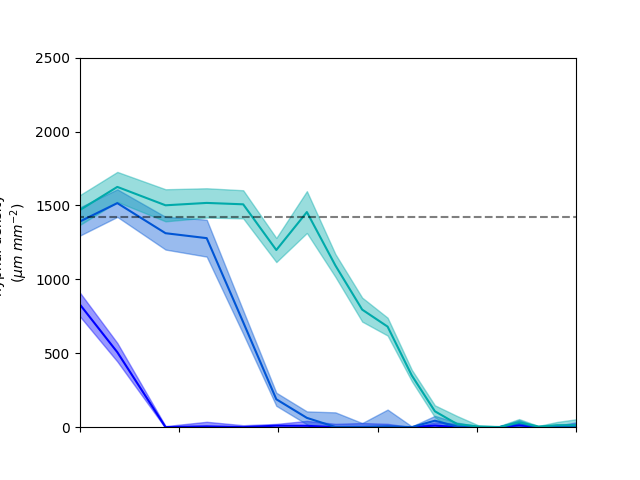

In [26]:
max_indexes = {plate : 20 for plate in plate_select}
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
# cmap = mpl.cm.get_cmap("Blues")
# cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
table_err = table_err.set_index('timestep',drop=False)

ts = list(table.index)
ts.sort()
dic = {}
f, ax  = plt.subplots()

ax.axis([10,35,0,2500])
# ax2.set_xlabel('distance from origin, $r$ (mm)', wrap=True)
ax.set_ylabel('hyphal density \n($\mu m$ $mm^{-2}$)') 
# ax2.set_ylim((0,0.25))
# ax2.set_ylabel('tip density \n ($mm^{-2}$)')
# ax.tick_params(axis='y', colors='blue')
# ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)

    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    # scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
ax.set_xticklabels([])
ax.hlines(Cmean,5,35,color='black',linestyle='--',alpha = 0.5)


C:\Users\coren\AppData\Local\Temp\ipykernel_13392\4036188627.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_13392\4036188627.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("winter")


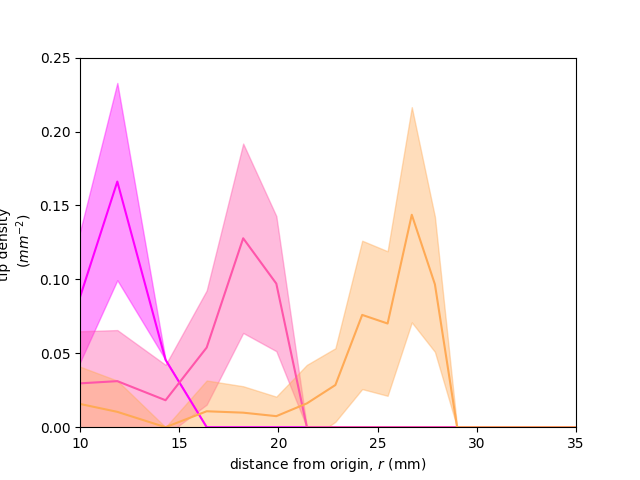

In [27]:
max_indexes = {plate : 20 for plate in plate_select}
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
# cmap = mpl.cm.get_cmap("Blues")
# cmap2 = mpl.cm.get_cmap("Reds")
plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
f, ax2  = plt.subplots()

# ax.axis([5,35,0,2500])
ax2.set_xlabel('distance from origin, $r$ (mm)', wrap=True)
# ax.set_ylabel('hyphae density \n($\mu m.mm^{-2}$)') 
ax2.set_ylim((0,0.25))
ax2.set_xlim((10,35))

ax2.set_ylabel('tip density \n ($mm^{-2}$)')
# ax.tick_params(axis='y', colors='blue')
# ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
timesteps = [25,50,75] 
lines_legends = []
labels = []
lines = []
markers = ['o','v','s']
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [err(x) for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    # scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i)/len(timesteps)),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    # ax.fill_between(xs, ys-err, ys+err,color=cmap((i)/len(timesteps)),alpha = 0.4)

    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [err(x) for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i)/len(timesteps)))
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    
    ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i)/len(timesteps)),alpha = 0.4)



C:\Users\coren\AppData\Local\Temp\ipykernel_13392\2719642304.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_13392\2719642304.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("winter")


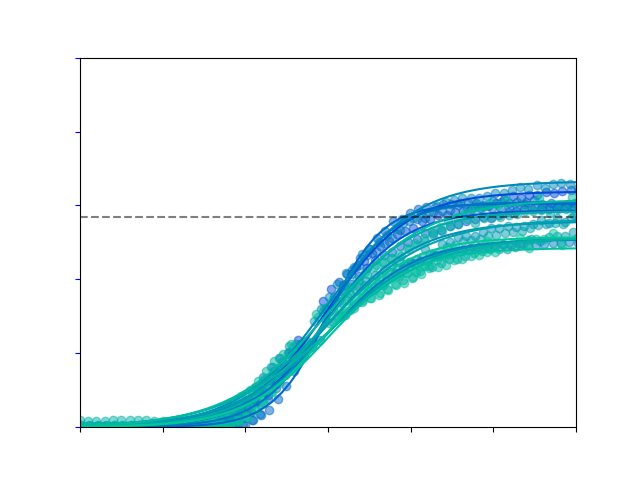

In [28]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=3

maxi = 15
max_area=50
fig,ax = plt.subplots()
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"] == plate].copy()
table_err = table_err.loc[table_err["timestep"] <= timestep_max]
table_err = table_err.set_index("timestep")
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}-new"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    table[column] = table_err[column]
    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    sorted_column = table.sort_values(by=column,ascending=True)
    if len(sorted_column.loc[sorted_column[column] >= 600])>2:
        start = sorted_column.loc[sorted_column[column] >= 600]["time_since_begin"].iloc[2]
        select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-50,start/pd.Timedelta(hours=1)+50)]
        select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=600)) | (select["time_since_begin"]<start)&(select[column]<=600)].copy()
        select[f"time_since_begin_{index}"] = (
            select["time_since_begin"] - start
        )/pd.Timedelta(hours=1)
        selection_fit = select
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        popt0, pcov = curve_fit(
            S,
            xis,
            yis,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
        lamb, C, t0 = list(popt0)
        select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

        ax.scatter(
            select[f"time_since_begin_{index}"],
            select[column],
            alpha=0.5,
            color=cmap2(area / max_area),
        )
        def statistic(x,y):
            try:
                popt0, pcov = curve_fit(
                S,
                x,
                y,
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[1, 1, 0],
            )
                return(popt0[1])
            except:
                return(C)
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        data = np.array((xis,yis))
        def statistic(x,y):
            try:
                popt0, pcov = curve_fit(
                S,
                x,
                y,
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[1, 1, 0],
            )
                return(popt0[2])
            except:
                return(C)
        xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
        data = np.array((xis,yis))
        x = np.linspace(-50, 50, 100)
        ax.plot(
            x,
            S(x + t0, lamb, C, t0),
            color=cmap2(area / max_area),
            label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
        )
        try:
            popt1, _ = curve_fit(
                dS,
                selection_fit[f"time_since_begin_{index}"],
                selection_fit[column2],
                bounds=([0, 0, -np.inf], 3 * [np.inf]),
                p0=[0.2, 0.5, 0],
            )
        except:
            continue
        lamb, C, t1 = list(popt1)


ax.set_xlim((-30, 30))
ax.set_ylim((0, 2500))

ax.tick_params(axis="y", colors="blue")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.hlines(Cmean,-30,30,color='black',linestyle='--',alpha = 0.5)


C:\Users\coren\AppData\Local\Temp\ipykernel_13392\197719392.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_13392\197719392.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("winter")


[Text(0, 0.0, ''),
 Text(0, 0.05, ''),
 Text(0, 0.1, ''),
 Text(0, 0.15000000000000002, ''),
 Text(0, 0.2, ''),
 Text(0, 0.25, '')]

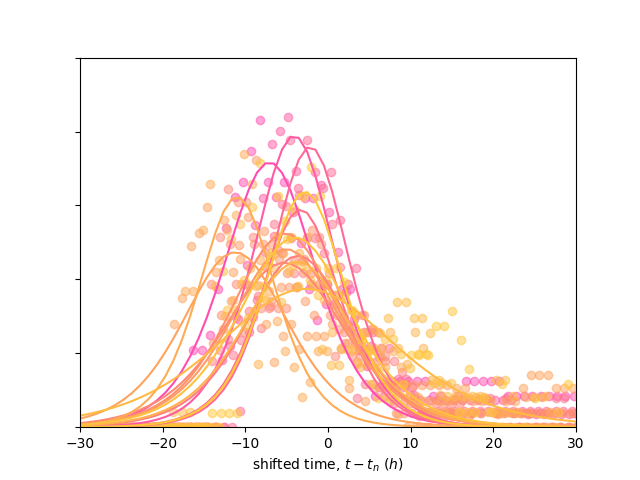

In [29]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=3

maxi = 15
max_area=50
fig,ax2 = plt.subplots()
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
Cstips2 = []

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"

    start = np.min(
        table.loc[table[column] >= 400]["time_since_begin"]
    )
    table[f"time_since_begin_{index}"] = (
        table["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)

    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = table
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]

    selection_fit = table

    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    table[f"time_since_begin_{index}"] = table[f"time_since_begin_{index}"] - t0

    # ax.scatter(
    #     table[f"time_since_begin_{index}"],
    #     table[column],
    #     alpha=0.5,
    #     color=cmap2(area / max_area),
    # )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    # ax.plot(
    #     x,
    #     S(x + t0, lamb, C, t0),
    #     color=cmap2(area / max_area),
    #     label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    # )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    Cstips2.append(C)
    ax2.scatter(
        table[f"time_since_begin_{index}"],
        table[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    ts += table[f"time_since_begin_{index}"].to_list()
    ys += table[column].to_list()
    ys2 += table[column2].astype(float).to_list()
df = pd.DataFrame(
    (np.array((ts, ys, ys2))).transpose(), columns=("ts", "ys", "ys2")
)
factor = 4
df["ts_round"] = (df["ts"] / factor).astype(int) * factor
meancurve = df.groupby("ts_round")["ys"].mean()
meancurve2 = df.groupby("ts_round")["ys2"].mean()
ax2.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))

ax2.set_xlabel("shifted time, $t-t_n$ ($h$)")
ax2.set_yticklabels([])


C:\Users\coren\AppData\Local\Temp\ipykernel_13392\2180735131.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = mpl.cm.get_cmap("spring")
C:\Users\coren\AppData\Local\Temp\ipykernel_13392\2180735131.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = mpl.cm.get_cmap("winter")
C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarnin

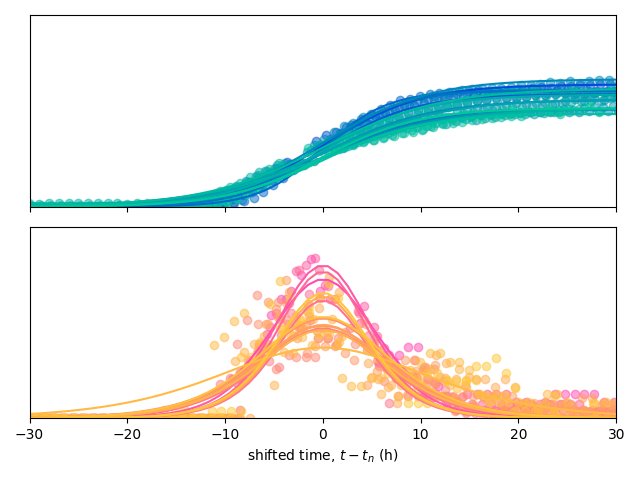

In [30]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
timestep_max = 130
n_resamples=1000

maxi = 15
max_area=50
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"] == plate].copy()
table_err = table_err.loc[table_err["timestep"] <= timestep_max]
table_err = table_err.set_index("timestep")
table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
table = table.loc[table["timestep"] <= timestep_max]
table = table.set_index("timestep")
ts = []
ys = []
ys2 = []
Cs = []
Cserror = []
t0serror = []
lambs = []
indexes = []
t0s = []
ds = []
Cstips2 = []

for index in range(1, maxi):
    column = f"ring_density_incr-100_index-{index}-new"
    column2 = f"ring_active_tips_density_incr-100_index-{index}"
    table[column] = table_err[column]
    sorted_column = table.sort_values(by=column,ascending=True)
    start = sorted_column.loc[sorted_column[column] >= 600]["time_since_begin"].iloc[2]
    select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-50,start/pd.Timedelta(hours=1)+50)]
    select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=600)) | (select["time_since_begin"]<start)&(select[column]<=600)].copy()
    select[f"time_since_begin_{index}"] = (
        select["time_since_begin"] - start
    )/pd.Timedelta(hours = 1)
    area = np.sqrt(table["area_sep_comp"][0] + 100 * index)
    selection_fit = select
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    popt0, pcov = curve_fit(
        S,
        xis,
        yis,
        bounds=([0, 0, -np.inf], 3 * [np.inf]),
        p0=[1, 1, 0],
    )
    lamb, C, t0 = list(popt0)
    select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

    ax.scatter(
        select[f"time_since_begin_{index}"],
        select[column],
        alpha=0.5,
        color=cmap2(area / max_area),
    )
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[1])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    Cserror.append(std)
    def statistic(x,y):
        try:
            popt0, pcov = curve_fit(
            S,
            x,
            y,
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[1, 1, 0],
        )
            return(popt0[2])
        except:
            return(C)
    xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
    data = np.array((xis,yis))
    std = scipy.stats.bootstrap(data,statistic,
                        vectorized = False,
                        method="basic",
                        n_resamples = n_resamples,
                        paired= True).standard_error
    t0serror.append(std)
    t0s.append(t0+start/pd.Timedelta(hours=1))
    
    Cs.append(C)
    lambs.append(lamb)
    indexes.append(index)
    ds.append(int(area / np.sqrt((np.pi / 2))))
    x = np.linspace(-50, 50, 100)
    ax.plot(
        x,
        S(x + t0, lamb, C, t0),
        color=cmap2(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    try:
        popt1, _ = curve_fit(
            dS,
            selection_fit[f"time_since_begin_{index}"],
            selection_fit[column2],
            bounds=([0, 0, -np.inf], 3 * [np.inf]),
            p0=[0.2, 0.5, 0],
        )
    except:
        continue
    lamb, C, t1 = list(popt1)
    Cstips2.append(C)
    ax2.scatter(
        select[f"time_since_begin_{index}"]-t1,
        select[column2],
        alpha=0.5,
        color=cmap1(area / max_area),
    )
    ax2.plot(
        x,
        dS(x +t1, lamb, C, t1),
        color=cmap1(area / max_area),
        label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
    )
    
ax.set_xlim((-30, 30))
ax2.set_ylim((0, 0.25))
ax.set_ylim((0, 2500))

ax2.set_xlabel("shifted time, $t-t_n$ (h)")
ax.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
ax.set_yticks([])  # Remove xticks
ax.set_ylabel('')
ax2.set_yticks([])  # Remove xticks
ax2.set_ylabel('') 
plt.tight_layout()


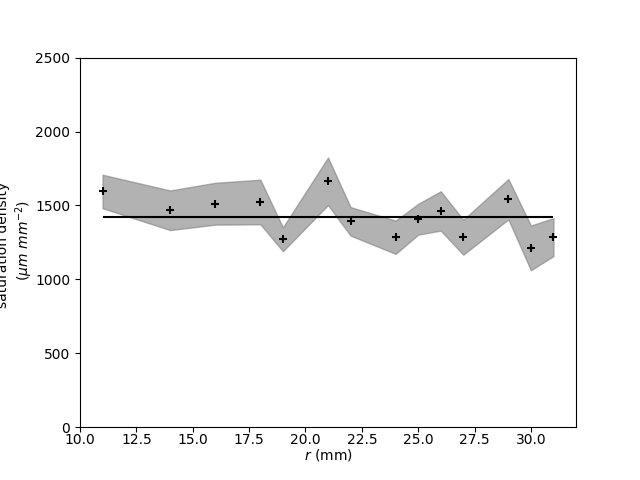

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('$r$ (mm)',labelpad=0.2)
ax.set_ylabel('saturation density \n ($\mu m$ $mm^{-2}$)',labelpad=0.4)
x0 = np.linspace(np.min(ds),np.max(ds),10)
err = np.array(Cserror)
ax.fill_between(ds, Cs-err, Cs+err,color="grey",alpha = 0.6)
X = sm.add_constant(ds, prepend=False)
model = sm.OLS(Cs,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.scatter(ds,Cs,marker="+",color="black")
ax.hlines(Cmean,min(ds),max(ds),color='black')

ax.set_ylim(0,2500)
ax.tick_params(axis='x', pad=0.7)



In [11]:
plates = [plate]
analysis_folders = analysis_folders.loc[analysis_folders['Plate'].isin(plates)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

In [12]:
plate = 94
plate_id = '94_20201123'

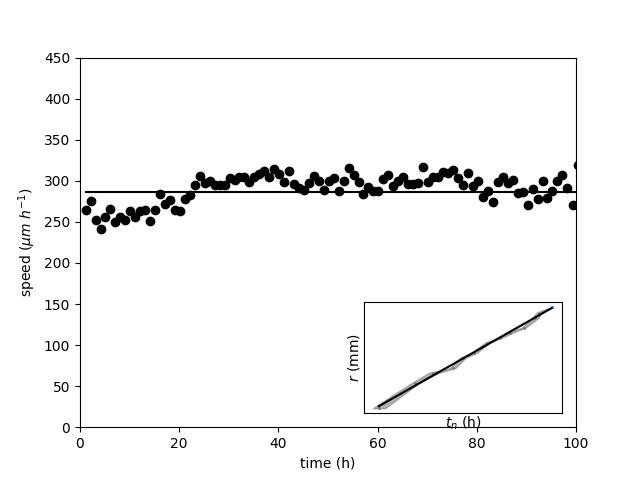

In [16]:
fig, axins2 = plt.subplots()
ax = inset_axes(axins2, width="40%", height="30%", loc=4, borderpad = 1)

ax.scatter(t0s,ds,label = "data",s = 1)
err = np.array(t0serror)/100
ax.fill_betweenx(ds, t0s-err, t0s+err,color="grey",alpha = 0.6)
X = sm.add_constant(t0s, prepend=False)
model = sm.OLS(ds,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(t0s,np.array(t0s)*a+b,label = f"linear fit : speed = {int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color='black')
ax.set_ylabel('$r$ (mm)')
ax.set_xlabel('$t_n$ (h)')
hull_speeds = []
hull_time = []
time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
if len(hyphae_hull)>0:
    label = 'hull pusher'
    for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        select = select.loc[select['speed'].between(200,350)]
        if len(select)>0:
            axins2.scatter((select['time_since_begin_h']/3.6e6).iloc[0],np.mean(select["speed"]),color='black')
            label = None
            hull_speeds.append(np.mean(select["speed"]))
            hull_time.append((select['time_since_begin_h']/3.6e6).iloc[0])

        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]

axins2.set_xlabel('time (h)')
axins2.set_ylabel('speed ($\mu m$ $h^{-1}$)')
ax.set_yticks([])  
ax.set_xticks([])  

ax.tick_params()

axins2.set_xlim(0,100)
axins2.set_ylim(0,450)

axins2.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
        color="black",
        label= f'mean hull pusher speed {int(np.mean(hull_speeds))}$\pm${int(2*np.std(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')


ax.xaxis.labelpad = 1
ax.yaxis.labelpad = 1